In [66]:
!pip -q install --upgrade pip
!pip -q install "hmmlearn>=0.3.2"


In [67]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, classification_report, confusion_matrix,
    accuracy_score, log_loss
)

In [68]:
#load weather data for SPI

weekly_SPI = pd.read_csv("weekly_spi6_gamma_only.csv", parse_dates=["date"]) #important columns: date & SPI_6
weekly_SPI.head()

,date,weekly_precip,precip_6mo,SPI_6
0,1970-07-05,29.633333,554.183333,NaN
1,1970-07-12,2.766667,555.350000,NaN
2,1970-07-19,23.783333,572.083333,NaN
3,1970-07-26,7.066667,576.266667,NaN
4,1970-08-02,27.283333,596.383333,NaN


We still have NaN values for SPI where the code previously couldnt calculate SPI due to lack of data so we need to get rid of those data points. Now the solution is somewhat roughly implemented, because there are some values of SPI for weeks 52 that show up way before the other week spi, because we cladsified week 53 as 52 so there is more representation. We get rid of these by just starting the time series in 1980. This is a hand made implementation - if we change the sample size in spi calc in weather code file this would need to be changed too.

In [69]:
weekly_SPI = weekly_SPI[weekly_SPI['SPI_6'].notna().cummax()]
weekly_SPI.head()
weekly_SPI["SPI_6_raw"] = weekly_SPI["SPI_6"]
if "date" in weekly_SPI.columns:
    weekly_SPI = weekly_SPI.sort_values("date")
else:
    weekly_SPI = weekly_SPI.sort_index()

weekly_SPI["SPI_6"] = weekly_SPI["SPI_6"].ffill()

In [70]:
nan_per_col = weekly_SPI.isna().sum().sort_values(ascending=False)
print(nan_per_col)

SPI_6_raw        77
date              0
weekly_precip     0
precip_6mo        0
SPI_6             0
dtype: int64


In [71]:
# 1) Parse the date column
weekly_SPI["date"] = pd.to_datetime(weekly_SPI["date"], errors="coerce")
weekly_SPI = weekly_SPI.dropna(subset=["date"])  # optional: drop rows with bad dates

# 2) Define bounds
lower_bound = pd.Timestamp("1980-06-28")
cutoff      = pd.Timestamp("2025-07-31")

# 3) Filter (exclusive)
mask = (weekly_SPI["date"] > lower_bound) & (weekly_SPI["date"] < cutoff)
weekly_SPI = weekly_SPI.loc[mask].reset_index(drop=True)


In [72]:
#creating df with columns date and spi_6 for certain functions
ws = weekly_SPI
if 'date' not in ws.columns:
    ws = ws.reset_index().rename(columns={'index': 'date'})

# keep only date + SPI_6, rename to spi_6, normalize date, sort, reindex
weekly_spi = (
    ws.loc[:, ['date', 'SPI_6']]
      .rename(columns={'SPI_6': 'spi_6'})
      .assign(date=lambda d: pd.to_datetime(d['date']))
      .sort_values('date')
      .reset_index(drop=True)
)

# quick check
print(weekly_spi.head())

        date     spi_6
0 1980-06-29  0.553616
1 1980-07-06 -1.046495
2 1980-07-13 -1.204234
3 1980-07-20 -1.343455
4 1980-07-27 -0.951979


In [73]:
def array(df,date_col, spi_col):
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)
    return X_all
array(weekly_spi,date_col="date", spi_col="spi_6")

array([[ 0.55361633],
       [-1.04649517],
       [-1.20423372],
       ...,
       [-0.11365856],
       [ 0.11053198],
       [ 0.29489092]])

In [74]:
# =========================
# Configuration of model parameters
# =========================
@dataclass
class HMMCfg:
    K_grid: Tuple[int, ...] = ( 3) # set to (2,3,4) when model runs porperly
    covariance_type: str = "tied"   # shared variance (good when data are limited)
    n_init: int = 5 #can increase but model will be slower
    max_iter: int = 300 #The Expectation–Maximization algorithm runs iteratively until convergence (change in log-likelihood < tolerance) - usually before 300 but just to be safe
    random_state: int = 0

@dataclass
class RunCfg:
    first_block_start: str = "1992-01-05"  # train on dates < this; forecast from this date
    block_years: int = 5                   # retrain cadence
    horizons: Tuple[int, ...] = (1,4)      # forecast horizons in weeks


In [75]:
# =========================
# Helper functions
# =========================
def _bic(ll, n_params, n_obs): # hmmlearn doesnt have an inherent bic score function so we set it up here
    return -2*ll + n_params*np.log(max(n_obs,1))

def _param_count_1d(K:int, cov_type:str)->int: #I need to know how many free parameters your HMM has in order to compute the BIC
    # start (K-1) + trans K*(K-1) + means K + variance params
    base = (K-1) + K*(K-1) + K
    return base + (1 if cov_type == "tied" else K) #because var is fixed in tied but not in diag or full

def reorder_states_by_mean(model: GaussianHMM) -> GaussianHMM:
    """
    Reorder states by ascending mean IN-PLACE.
    Never assign to covars_ when covariance_type='tied'.
    """
    order = np.argsort(model.means_.ravel())

    # Reorder startprob and transmat
    model.startprob_ = model.startprob_[order]
    model.transmat_  = model.transmat_[order][:, order]

    # Reorder means
    model.means_ = model.means_[order]

    # Only per-state covariances should be permuted
    if model.covariance_type in ("full", "diag", "spherical"):
        model.covars_ = model.covars_[order]

    return model





In [76]:
# =========================
# Helper functions pt2
# =========================

def fit_best_hmm_1d(X: np.ndarray, cfg: HMMCfg) -> GaussianHMM:
    """Fit over K_grid, pick best by BIC, reorder states by mean (dry->wet)."""
    X = np.asarray(X).reshape(-1, 1)
    if not np.isfinite(X).all():
        raise ValueError("X contains NaN/Inf")

    best_bic, best_model = np.inf, None
    for K in cfg.K_grid:
        best_ll, best_k = -np.inf, None
        for seed in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,
                n_iter=cfg.max_iter,
                random_state=cfg.random_state + seed
            )
            m.fit(X)
            ll = m.score(X)
            if ll > best_ll:
                best_ll, best_k = ll, m

        bic = _bic(best_ll, _param_count_1d(K, cfg.covariance_type), len(X))
        if bic < best_bic:
            best_bic, best_model = bic, best_k

    if best_model is None:
        raise RuntimeError("No successful fits.")

    # ✅ Use the new, in-place reordering (NO underscore)
    return reorder_states_by_mean(best_model)

# in order to get 4 weeks ahead transition prob we need to get a function that calc the trans prob matrix for four weeks in advance
def T_power(T: np.ndarray, h: int) -> np.ndarray:
    return np.linalg.matrix_power(T, h)

def causal_state_probs_at_t(model: GaussianHMM, X_all: np.ndarray, t: int) -> np.ndarray:
    """
    Causal state probabilities at time t using hmmlearn only:
    run predict_proba on the PREFIX X[:t+1] and take the last row.
    (No future observations beyond t are used.)
    """
    post = model.predict_proba(X_all[:t+1])   # (t+1, K)
    return post[-1]                            # (K,)


In [77]:
# =========================
# Main: train-then-freeze, 5y blocks, per-state probs only
# =========================
def hmm_per_state_blockwise(df: pd.DataFrame,#input df with both date and spi
                            date_col="date", spi_col="spi_6",
                            hmm_cfg=HMMCfg(), run_cfg=RunCfg()):
    """
    - Train on dates < first_block_start.
    - For each 5-year block: refit on dates < block start (expanding window),
      then freeze and forecast each week in the block without using future weeks.
    - Output per-state probabilities at each horizon (no aggregates).
    """
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)

    #It'll train on data < block start and forecast within the block
    first_start = pd.Timestamp(run_cfg.first_block_start)
    last_date   = dates.iloc[-1]
    start_year  = first_start.year
    end_year    = last_date.year
    block_starts = [pd.Timestamp(year=y, month=1, day=1)
                    for y in range(start_year, end_year+1, run_cfg.block_years)]

    #Start the output table (will add columns as we go)
    out = df[[date_col, spi_col]].copy()
    made_cols_for = set()  # remember (K, horizons) we've added columns for

    for b_start in block_starts:
        b_end_excl = pd.Timestamp(year=b_start.year + run_cfg.block_years, month=1, day=1)
        b_end = min(b_end_excl - pd.Timedelta(days=1), last_date) # compute the inclusive end date - 5y minus 1 day

        train_mask = dates < b_start
        if train_mask.sum() < 50:
            print(f"Skip block {b_start.date()}–{b_end.date()} (not enough training data).")
            continue
        # fit the best HMM on the training prefix
        X_train = X_all[train_mask.values]
        model   = fit_best_hmm_1d(X_train, hmm_cfg)
        T       = model.transmat_ #transition probability matrix of shape kxk
        K       = model.n_components #number of states

        # prepare output columns before you start filling them with HMM forecast probabilities
        key = (K, tuple(sorted(run_cfg.horizons)))
        if key not in made_cols_for:
            for h in run_cfg.horizons:
                for s in range(K):
                    col = f"p_state{s}_h{h}"
                    if col not in out.columns:
                        out[col] = np.nan
            made_cols_for.add(key)

        Tpow = {h: T_power(T, h) for h in run_cfg.horizons}

        #row indices to recognize where the current block is
        block_mask = (dates >= b_start) & (dates <= b_end) # true where the observation’s date falls inside the current 5-year block, false otherwise
        idxs = np.where(block_mask)[0] #converts that boolean mask into the actual row indices

        for t in idxs:
            # causal belief at time t from prefix only
            g_t = causal_state_probs_at_t(model, X_all, t)   # (K,)
            for h in run_cfg.horizons:
                g_th = g_t @ Tpow[h]                          # (K,)
                for s in range(K):
                    out.at[t, f"p_state{s}_h{h}"] = float(g_th[s])

        #block summary in the notebook output
        print(f"Block {b_start.date()}–{b_end.date()}: "
              f"train_weeks={train_mask.sum()}, block_weeks={block_mask.sum()}, K={K}")

    return out


In [78]:
# ===========
# Computing the model - execution
# ===========

results = hmm_per_state_blockwise(
    df = weekly_spi, date_col="date", spi_col="spi_6",
    hmm_cfg=HMMCfg(covariance_type="tied", K_grid=(2,3), n_init=5, max_iter=300),
    run_cfg=RunCfg(first_block_start="1992-01-05", block_years=5, horizons=(1,4))
)


Block 1992-01-01–1996-12-31: train_weeks=601, block_weeks=261, K=3
Block 1997-01-01–2001-12-31: train_weeks=862, block_weeks=261, K=3
Block 2002-01-01–2006-12-31: train_weeks=1123, block_weeks=261, K=3
Block 2007-01-01–2011-12-31: train_weeks=1384, block_weeks=260, K=3
Block 2012-01-01–2016-12-31: train_weeks=1644, block_weeks=261, K=3
Block 2017-01-01–2021-12-31: train_weeks=1905, block_weeks=261, K=3
Block 2022-01-01–2025-07-27: train_weeks=2166, block_weeks=187, K=3


In [79]:
def save_h1_probs_csv(
    results: pd.DataFrame,
    out_path: str = "state_probs_h1.csv",
    date_col: str = "date",
    start_date: str | None = "1992-01-01",
):
    df = results.copy()

    # Ensure datetime index for filtering/sorting
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")

    # Grab all h=1 state probability columns
    prob_cols = [c for c in df.columns if c.startswith("p_state") and c.endswith("_h1")]
    if not prob_cols:
        raise KeyError("No state probability columns for h=1 found (e.g., 'p_state0_h1').")

    # Optional start-date filter
    if start_date is not None:
        df = df.loc[df.index >= pd.to_datetime(start_date)]

    # Build output with date as a column
    out = df[prob_cols].copy()
    out.insert(0, "date", out.index)  # move datetime index to a column

    # Save
    out.to_csv(out_path, index=False)
    return out_path

# --- usage ---
path = save_h1_probs_csv(results, out_path="h1_probs.csv")



In [80]:
#plotting dry period probs

def plot_state0_probs(results: pd.DataFrame, horizons=(1, 4), title="State 0 (driest) probabilities over time"):
    """
    Plots p_state0_h{h} over time for the given horizons.
    Expects columns: 'date', and for each h in horizons, 'p_state0_h{h}'.
    """
    # Ensure datetime & sort
    df = results.copy()
    if 'date' not in df.columns:
        raise ValueError("Expected a 'date' column in results.")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # Prepare figure
    plt.figure(figsize=(12, 4))

    # Plot each horizon if present
    plotted_any = False
    for h in horizons:
        col = f"p_state0_h{h}"
        if col in df.columns:
            plt.plot(df['date'], df[col], label=f"h={h}")
            plotted_any = True
        else:
            print(f"[warn] Column '{col}' not found; skipping.")

    if not plotted_any:
        raise ValueError(f"None of the requested horizons found: {horizons}. "
                         f"Available columns: {[c for c in results.columns if c.startswith('p_state0_h')]}")

    plt.ylabel("Probability")
    plt.xlabel("Date")
    plt.title(title)
    plt.ylim(0.0, 1.0)
    plt.grid(True, linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

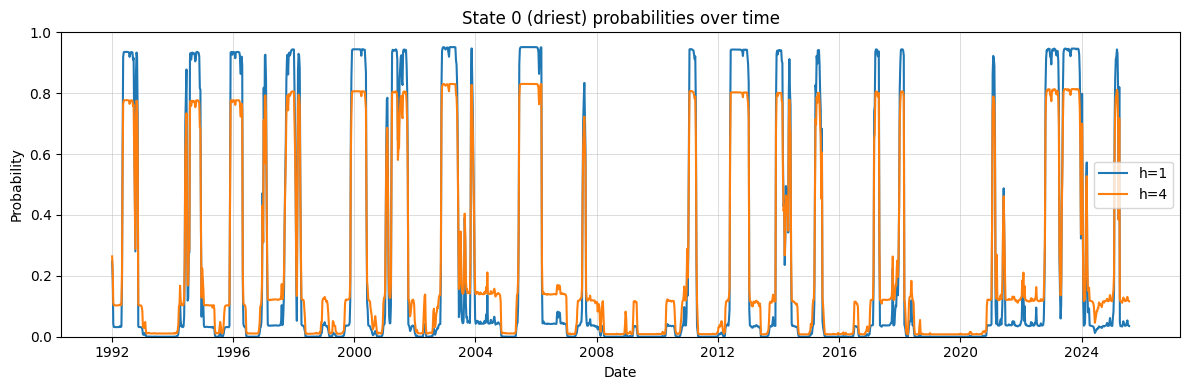

In [81]:
plot_state0_probs(results, horizons=(1, 4))

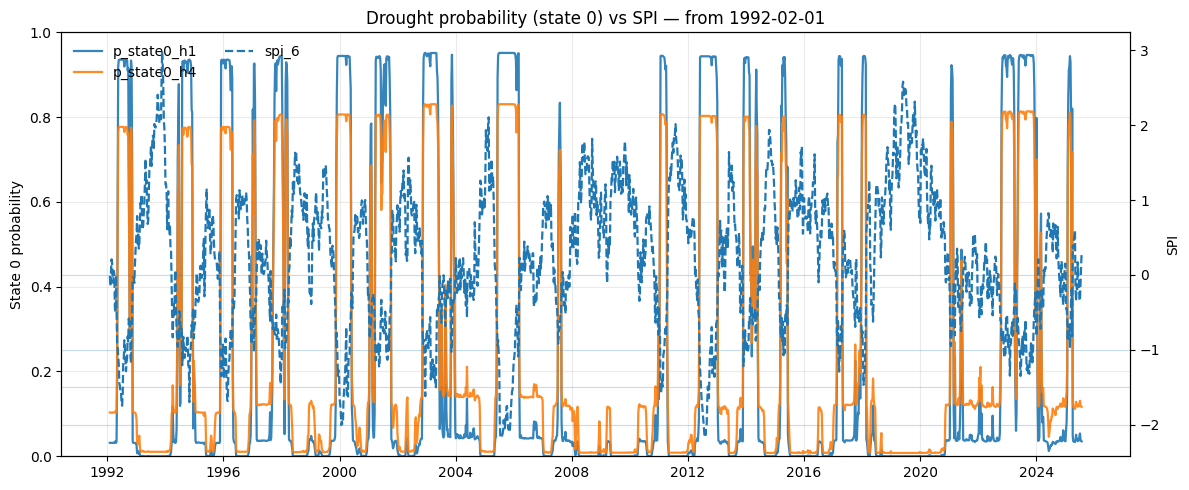

In [82]:
def plot_drought_prob_and_spi(
    results: pd.DataFrame,
    date_col: str = "date",
    spi_col: str = "spi_6",
    prob_cols: tuple[str, ...] = ("p_state0_h1", "p_state0_h4"),
    start_date: str = "1992-02-01",
    figsize=(12, 5)
):
    """
    Line chart of state-0 probabilities and SPI on the same figure.
    - Left y-axis: probabilities (0..1)
    - Right y-axis: SPI values
    - Filters data to dates >= start_date
    """
    df = results.copy()

    # Ensure datetime index for filtering/plotting
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Provide a datetime 'date' column or index must be a DatetimeIndex.")

    # Keep only needed cols that exist
    avail_probs = [c for c in prob_cols if c in df.columns]
    needed = [spi_col] + avail_probs
    missing = [c for c in [spi_col] + list(prob_cols) if c not in df.columns]
    if spi_col not in df.columns:
        raise KeyError(f"Missing SPI column: {spi_col}")
    if not avail_probs:
        raise KeyError(f"None of the probability columns found: {prob_cols}")
    if missing:
        print(f"Note: missing columns not plotted: {missing}")

    plot_df = df.loc[df.index >= pd.to_datetime(start_date), needed].copy()

    fig, ax_prob = plt.subplots(figsize=figsize)

    # Plot probabilities (left axis)
    handles = []
    labels = []
    for i, c in enumerate(avail_probs):
        (ln,) = ax_prob.plot(plot_df.index, plot_df[c], lw=1.6, alpha=0.9, label=c)
        handles.append(ln); labels.append(c)

    ax_prob.set_ylabel("State 0 probability")
    ax_prob.set_ylim(0, 1)
    ax_prob.grid(True, which="major", axis="both", alpha=0.25)

    # SPI on right axis
    ax_spi = ax_prob.twinx()
    (ln_spi,) = ax_spi.plot(plot_df.index, plot_df[spi_col], lw=1.6, linestyle="--", label=spi_col)
    ax_spi.set_ylabel("SPI")
    # Light guides for common SPI categories
    for y in [0.0, -1.0, -1.5, -2.0]:
        ax_spi.axhline(y=y, lw=0.8, alpha=0.25)

    # Legend (combine both axes)
    handles2, labels2 = ax_spi.get_legend_handles_labels()
    handles_all = handles + handles2
    labels_all  = labels + labels2
    ax_prob.legend(handles_all, labels_all, loc="upper left", frameon=False, ncol=2)

    title_probs = ", ".join(avail_probs)
    ax_prob.set_title(f"Drought probability (state 0) vs SPI — from {pd.to_datetime(start_date).date()}")

    fig.tight_layout()
    plt.show()

# ---- usage ----
plot_drought_prob_and_spi(results)


In [83]:
data = results.dropna().copy()

In [84]:

def spi_prob_lagged_corr(
    results: pd.DataFrame,
    spi_col: str = "spi_6",
    prob_cols: tuple[str, str] = ("p_state0_h1", "p_state0_h4"),
    date_col: str | None = "date",
    start_date: str = "1992-02-01",
    max_lag_weeks: int = 52,
) -> pd.DataFrame:
    """
    Correlate today's SPI with state-0 probabilities from the same day (lag=0)
    and from 1..max_lag_weeks weeks ago.

    Returns a DataFrame with columns:
      lag_weeks, corr_h1, n_h1, corr_h4, n_h4
    """
    df = results.copy()

    # Ensure we have a datetime index/column for filtering and sort by date
    if date_col and date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    else:
        # assume index is already datetime-like
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")
        df = df.sort_index()

    # Keep only the needed columns & from start_date
    needed = [spi_col, *prob_cols]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    df = df.loc[df.index >= pd.to_datetime(start_date), needed].copy()

    # Prepare output container
    out_rows = []
    h1, h4 = prob_cols

    # Compute correlations for lags 0..max_lag_weeks
    for lag in range(0, max_lag_weeks + 1):
        # Align: correlate SPI_t with prob_{t - lag}
        prob_h1_lag = df[h1].shift(lag)
        prob_h4_lag = df[h4].shift(lag)

        # Pairwise-drop NaNs per pair
        s_spi = df[spi_col]

        # h1
        mask_h1 = s_spi.notna() & prob_h1_lag.notna()
        corr_h1 = np.nan
        n_h1 = int(mask_h1.sum())
        if n_h1 >= 2:
            corr_h1 = float(s_spi[mask_h1].corr(prob_h1_lag[mask_h1]))

        # h4
        mask_h4 = s_spi.notna() & prob_h4_lag.notna()
        corr_h4 = np.nan
        n_h4 = int(mask_h4.sum())
        if n_h4 >= 2:
            corr_h4 = float(s_spi[mask_h4].corr(prob_h4_lag[mask_h4]))

        out_rows.append({
            "lag_weeks": lag,
            "corr_h1": corr_h1,
            "n_h1": n_h1,
            "corr_h4": corr_h4,
            "n_h4": n_h4,
        })

    out = pd.DataFrame(out_rows).set_index("lag_weeks")
    return out

# ---- usage ----


In [85]:
 corr_table = spi_prob_lagged_corr(results)
 corr_table.head(), corr_table.loc[[0,1,4,12,26,52]]
# If you want the best (most negative/positive) lag quickly:
# best_neg_h1 = corr_table['corr_h1'].idxmin()
# best_pos_h1 = corr_table['corr_h1'].idxmax()
# best_neg_h4 = corr_table['corr_h4'].idxmin()
# best_pos_h4 = corr_table['corr_h4'].idxmax()




(            corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.776662  1748 -0.825612  1748
 1         -0.743688  1747 -0.791607  1747
 2         -0.712863  1746 -0.759356  1746
 3         -0.680500  1745 -0.725790  1745
 4         -0.645944  1744 -0.690359  1744,
             corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.776662  1748 -0.825612  1748
 1         -0.743688  1747 -0.791607  1747
 4         -0.645944  1744 -0.690359  1744
 12        -0.375499  1736 -0.408981  1736
 26         0.044900  1722  0.032477  1722
 52         0.077112  1696  0.073046  1696)

In [86]:
def add_spi3class_and_score(
    df: pd.DataFrame,
    *,
    spi_col: str = "spi_6",
    horizon: int = 1,                          # compare probs at t to SPI class at t+h
    prob_col_tpl: str = "p_state{state}_h{h}", # how your columns are named
    dry_thr: float = -0.5, #from -0.5 to 0.5 is the nearly normal area of SPI above or below is midly dry and wet
    wet_thr: float =  0.5,
    train_mask: pd.Series | np.ndarray | None = None,   # boolean mask used to learn mapping
    state_to_class: dict[int, int] | None = None        # optional manual mapping {state: 0/1/2}
):
    """
    Adds 3-class SPI labels and scores HMM classification for a given horizon.

    df must already contain the state-probability columns for the chosen horizon, e.g.:
      p_state0_h1, p_state1_h1, p_state2_h1  (for horizon=1)

    Returns:
      metrics: dict with accuracy, confusion matrix, per-class report, brier-ish score,
               log loss (if all probs > 0), and the inferred state->class mapping.
      df: with new columns:
            - 'spi3' (0=dry,1=neutral,2=wet) at time t
            - 'spi3_tplus{h}' target labels at time t+h
            - 'pred3_{h}' argmax class predicted at time t
            - 'proba3_{h}_dry', 'proba3_{h}_neutral', 'proba3_{h}_wet'
    """
    C = 3
    h = horizon

    # 0) Build SPI -> 3-class labels at t and t+h
    def spi_to_3(spi):
        y = np.full_like(spi, 1, dtype=int)   # neutral
        y[spi <= dry_thr] = 0                 # dry
        y[spi >=  wet_thr] = 2               # wet
        return y

    df = df.copy()
    df["spi3"] = spi_to_3(df[spi_col].to_numpy())
    df[f"spi3_tplus{h}"] = df["spi3"].shift(-h)   # target at t+h

    # 1) Collect the K=3 probability columns for this horizon
    prob_cols = [prob_col_tpl.format(state=s, h=h) for s in range(3)]
    for c in prob_cols:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    P = df[prob_cols].to_numpy()  # shape (T, 3), rows sum ~1
    T, K = P.shape
    assert K == 3, "This helper assumes K=3 states."

    # 2) Learn or use a mapping: state -> class (0=dry,1=neutral,2=wet)
    #    If not provided, infer on the training slice by ordering states by mean SPI
    #    (lowest mean -> dry, middle -> neutral, highest -> wet).
    if state_to_class is None:
        if train_mask is None:
            # default: use all non-na rows up to where target exists
            train_mask = pd.Series(True, index=df.index)
        else:
            train_mask = pd.Series(train_mask, index=df.index)

        # Use only rows where SPI and probs exist AND target exists (avoid leakage)
        valid_train = train_mask & df[spi_col].notna() & (~df[f"spi3_tplus{h}"].isna())
        if valid_train.sum() < 10:
            # fallback: just order by overall mean if train slice too small
            valid_train = df[spi_col].notna()

        spi_vals = df.loc[valid_train, spi_col].to_numpy()
        P_train  = P[valid_train.to_numpy(), :]

        # weighted mean SPI per state (soft responsibilities)
        state_means = []
        for s in range(3):
            w = P_train[:, s]
            denom = w.sum()
            m = (w @ spi_vals) / denom if denom > 0 else np.inf
            state_means.append(m)

        # map by ascending mean: low -> dry(0), mid -> neutral(1), high -> wet(2)
        order = np.argsort(state_means)  # indices of states from driest to wettest
        inferred_mapping = {int(order[0]): 0, int(order[1]): 1, int(order[2]): 2}
        mapping = inferred_mapping
    else:
        mapping = dict(state_to_class)

    # 3) Aggregate state probabilities into class probabilities at time t
    proba3 = np.zeros((T, C), dtype=float)
    for s, c in mapping.items():
        proba3[:, c] += P[:, s]

    # 4) Hard prediction at time t (argmax over class probs)
    y_pred = proba3.argmax(axis=1)

    # 5) Targets are SPI class at t+h
    y_true = df[f"spi3_tplus{h}"].to_numpy()

    # 6) Keep only rows where target exists
    mask_eval = ~np.isnan(y_true)
    y_true = y_true[mask_eval].astype(int)
    y_pred_eval = y_pred[mask_eval]
    proba3_eval = proba3[mask_eval]

    # 7) Metrics
    acc = accuracy_score(y_true, y_pred_eval)
    cm  = confusion_matrix(y_true, y_pred_eval, labels=[0,1,2])
    report = classification_report(
        y_true, y_pred_eval, labels=[0,1,2],
        target_names=["dry","neutral","wet"], digits=3
    )

    # Brier-like score (mean squared error of the prob vector vs. one-hot)
    one_hot = np.eye(3)[y_true]
    brier = float(np.mean((proba3_eval - one_hot) ** 2))

    # log loss (guard against zeros)
    eps = 1e-12
    proba_safe = np.clip(proba3_eval, eps, 1 - eps)
    ll = log_loss(y_true, proba_safe, labels=[0,1,2])

    # 8) Attach columns
    df[f"proba3_{h}_dry"]     = proba3[:, 0]
    df[f"proba3_{h}_neutral"] = proba3[:, 1]
    df[f"proba3_{h}_wet"]     = proba3[:, 2]
    df[f"pred3_{h}"]          = y_pred

    metrics = {
        "horizon": h,
        "state_to_class": mapping,         # {state: 0/1/2}
        "accuracy": acc,
        "confusion_matrix": cm,
        "classification_report": report,
        "brier_like": brier,
        "log_loss": ll
    }
    return df, metrics


In [87]:
# ---------- Helpers ----------
def brier_score(y_true, proba):
    """Multi-class Brier (mean squared error vs. one-hot)."""
    one_hot = np.eye(proba.shape[1])[y_true]
    return float(np.mean((proba - one_hot) ** 2))

def brier_decomposition(y_true, proba):
    """
    Murphy (1973) decomposition: Brier = reliability - resolution + uncertainty
    Using equal-width bins per class (10 bins).
    """
    K = proba.shape[1]
    one_hot = np.eye(K)[y_true]
    p_bar = one_hot.mean(axis=0)  # climatological class frequencies
    uncertainty = float(np.sum(p_bar * (1 - p_bar)))  # sum_k p_k (1 - p_k)

    # Reliability & Resolution via per-class binning
    n_bins = 10
    reliability = 0.0
    resolution  = 0.0
    for k in range(K):
        pk = proba[:, k]
        yk = one_hot[:, k]
        bins = np.linspace(0, 1, n_bins + 1)
        idx = np.digitize(pk, bins) - 1  # 0..n_bins-1
        for b in range(n_bins):
            mask = idx == b
            if not np.any(mask):
                continue
            p_bin = pk[mask].mean()
            o_bin = yk[mask].mean()
            w = mask.mean()
            reliability += w * (p_bin - o_bin) ** 2
        # Resolution is variance of conditional event rate around climatology
        # (approximate by grouping using same bins)
        o_vals = []
        w_vals = []
        for b in range(n_bins):
            mask = idx == b
            if not np.any(mask):
                continue
            o_vals.append(yk[mask].mean())
            w_vals.append(mask.mean())
        if o_vals:
            o_vals = np.array(o_vals)
            w_vals = np.array(w_vals)
            resolution += float(np.sum(w_vals * (o_vals - p_bar[k]) ** 2))

    return {
        "brier": reliability - resolution + uncertainty,
        "reliability": float(reliability),
        "resolution": float(resolution),
        "uncertainty": float(uncertainty),
    }

def ranked_probability_score(y_true, proba):
    """
    RPS for ordered 3 classes (0=dry,1=neutral,2=wet).
    RPS = sum_{k=1..K-1} (CDF_forecast(k) - CDF_obs(k))^2
    """
    K = proba.shape[1]
    one_hot = np.eye(K)[y_true]
    cdf_f = np.cumsum(proba, axis=1)
    cdf_o = np.cumsum(one_hot, axis=1)
    # exclude last CDF step (always 1)
    diff = cdf_f[:, :K-1] - cdf_o[:, :K-1]
    return float(np.mean(np.sum(diff**2, axis=1)))

def ranked_probability_skill_score(y_true, proba, climatology):
    """
    RPSS = 1 - RPS_forecast / RPS_climatology
    climatology: length-K vector of class frequencies
    """
    K = proba.shape[1]
    P_clim = np.broadcast_to(climatology.reshape(1, K), proba.shape)
    rps_f = ranked_probability_score(y_true, proba)
    rps_c = ranked_probability_score(y_true, P_clim)
    return float(1.0 - rps_f / rps_c) if rps_c > 0 else np.nan

def expected_calibration_error(y_true, proba, n_bins=10):
    """
    Multiclass ECE (OvR): average (weighted by bin size) gap between predicted prob
    and empirical frequency, averaged over classes and bins.
    """
    K = proba.shape[1]
    one_hot = np.eye(K)[y_true]
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    mce = 0.0
    total = len(y_true)
    # Keep a reliability table too
    rows = []
    for k in range(K):
        pk = proba[:, k]
        yk = one_hot[:, k]
        idx = np.digitize(pk, bins) - 1
        for b in range(n_bins):
            mask = idx == b
            count = mask.sum()
            if count == 0:
                continue
            conf = pk[mask].mean()
            acc  = yk[mask].mean()  # empirical freq of class k in the bin
            gap = abs(conf - acc)
            weight = count / total
            ece += weight * gap
            mce = max(mce, gap)
            rows.append({
                "class": k, "bin": b,
                "count": int(count),
                "mean_confidence": float(conf),
                "empirical_freq": float(acc),
                "gap": float(gap),
            })
    calib_table = pd.DataFrame(rows)
    return float(ece), float(mce), calib_table

def entropy(proba, eps=1e-12):
    p = np.clip(proba, eps, 1 - eps)
    return float(-np.mean(np.sum(p * np.log(p), axis=1)))

def binary_event_metrics(y_true, proba, positive_class, threshold=0.5):
    """
    Treat a given class as an 'event' vs the rest.
    Returns precision, recall, f1, TSS (Peirce), hit rate, false alarm ratio.
    """
    y_bin_true = (y_true == positive_class).astype(int)
    y_bin_prob = proba[:, positive_class]
    y_bin_pred = (y_bin_prob >= threshold).astype(int)

    # Confusion terms
    TP = int(np.sum((y_bin_true == 1) & (y_bin_pred == 1)))
    FP = int(np.sum((y_bin_true == 0) & (y_bin_pred == 1)))
    TN = int(np.sum((y_bin_true == 0) & (y_bin_pred == 0)))
    FN = int(np.sum((y_bin_true == 1) & (y_bin_pred == 0)))

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

    # Hit rate (POD/recall) and False Alarm Ratio (FAR)
    hit_rate = rec
    far = FP / (TP + FP) if (TP + FP) > 0 else 0.0

    # True Skill Statistic (Peirce) = TPR - FPR
    tpr = rec
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    tss = tpr - fpr

    return {
        "threshold": threshold,
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "hit_rate": float(hit_rate),
        "false_alarm_ratio": float(far),
        "tss": float(tss),
        "confusion": {"TP": TP, "FP": FP, "TN": TN, "FN": FN}
    }

def persistence_baseline(y_true_full, y_pred_at_t_full, mask_eval):
    """
    Persistence for h>0: predict class at t+h as class at t.
    y_pred_at_t_full: class at t (e.g., df['spi3'].values)
    y_true_full:      class at t+h (e.g., df[f'spi3_tplus{h}'].values)
    mask_eval:        boolean mask used in add_spi3class_and_score
    """
    y_true = y_true_full[mask_eval].astype(int)
    y_pers = y_pred_at_t_full[mask_eval].astype(int)
    acc = accuracy_score(y_true, y_pers)
    cm = confusion_matrix(y_true, y_pers, labels=[0,1,2])
    return float(acc), cm

# ---------- Main augmentor ----------
def enrich_hmm_metrics(df_scored: pd.DataFrame, metrics: dict, *,
                       horizon: int,
                       spi_col: str = "spi_6",
                       dry_class=0, neutral_class=1, wet_class=2,
                       event_threshold: float = 0.5,
                       train_mask: pd.Series | np.ndarray | None = None):
    """
    Takes the outputs from add_spi3class_and_score (df_scored, metrics)
    and adds: RPS/RPSS, calibration (ECE/MCE + reliability table), OvR ROC-AUC & PR-AUC,
    event metrics for dry & wet, baselines (climatology & persistence), entropy, and brier decomposition.
    """
    h = horizon
    # Extract evaluation slice from earlier function
    y_true_full = df_scored[f"spi3_tplus{h}"].to_numpy()
    proba = np.vstack([
        df_scored[f"proba3_{h}_dry"].to_numpy(),
        df_scored[f"proba3_{h}_neutral"].to_numpy(),
        df_scored[f"proba3_{h}_wet"].to_numpy()
    ]).T
    y_pred_at_t_full = df_scored["spi3"].to_numpy()  # persistence anchor

    mask_eval = ~np.isnan(y_true_full)
    y_true = y_true_full[mask_eval].astype(int)
    proba_eval = proba[mask_eval]

    # --- Climatology (by training slice if provided, else by eval slice) ---
    if train_mask is None:
        clim_counts = np.bincount(y_true, minlength=3).astype(float)
    else:
        m = pd.Series(train_mask, index=df_scored.index).fillna(False).to_numpy()
        # make sure target exists in training to avoid leakage
        m = m & (~np.isnan(y_true_full))
        clim_counts = np.bincount(y_true_full[m].astype(int), minlength=3).astype(float)
        if clim_counts.sum() == 0:
            clim_counts = np.bincount(y_true, minlength=3).astype(float)
    clim_freq = clim_counts / clim_counts.sum() if clim_counts.sum() > 0 else np.array([1/3,1/3,1/3])

    # --- Proper scores & calibration ---
    ll = log_loss(y_true, np.clip(proba_eval, 1e-12, 1-1e-12), labels=[0,1,2])
    bs = brier_score(y_true, proba_eval)
    bd = brier_decomposition(y_true, proba_eval)

    rps  = ranked_probability_score(y_true, proba_eval)
    rpss = ranked_probability_skill_score(y_true, proba_eval, climatology=clim_freq)

    ece, mce, calib_table = expected_calibration_error(y_true, proba_eval, n_bins=10)
    sharpness_entropy = entropy(proba_eval)

    # --- Discrimination: OvR AUCs ---
    auc_ovr = {}
    ap_ovr  = {}
    for c, name in zip([dry_class, neutral_class, wet_class], ["dry","neutral","wet"]):
        y_bin = (y_true == c).astype(int)
        auc_ovr[name] = float(roc_auc_score(y_bin, proba_eval[:, c]))
        ap_ovr[name]  = float(average_precision_score(y_bin, proba_eval[:, c]))

    # --- Event metrics for dry and wet at a working threshold ---
    dry_event = binary_event_metrics(y_true, proba_eval, positive_class=dry_class, threshold=event_threshold)
    wet_event = binary_event_metrics(y_true, proba_eval, positive_class=wet_class, threshold=event_threshold)

    # --- Baselines ---
    # climatology 'accuracy' via random draw isn't well-defined; report log loss & RPS baseline instead
    # persistence accuracy:
    acc_persist, cm_persist = persistence_baseline(y_true_full, y_pred_at_t_full, mask_eval)

    # Package everything
    extra = {
        "proper_scores": {
            "log_loss": float(ll),
            "brier": float(bs),
            "brier_decomposition": bd,  # reliability, resolution, uncertainty
            "rps": float(rps),
            "rpss_vs_climatology": float(rpss),
        },
        "calibration": {
            "ece": float(ece),
            "mce": float(mce),
            "reliability_table": calib_table,  # DataFrame
        },
        "discrimination": {
            "roc_auc_ovr": auc_ovr,
            "pr_auc_ovr": ap_ovr,
        },
        "events": {
            "dry": dry_event,
            "wet": wet_event,
            "threshold_used": float(event_threshold),
        },
        "baselines": {
            "climatology_class_freq": clim_freq.tolist(),
            "persistence_accuracy": float(acc_persist),
            "persistence_confusion_matrix": cm_persist,
        },
        "sharpness": {
            "mean_entropy": float(sharpness_entropy)
        }
    }
    # Merge into your original metrics dict (don’t overwrite existing keys)
    out = metrics.copy()
    out.update(extra)
    return out


In [88]:
# You already have:
df_scored, m1 = add_spi3class_and_score(
    df=data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h{h}",
    # train_mask=...  # optional
)

m1_full = enrich_hmm_metrics(
    df_scored, m1, horizon=1, spi_col="spi_6",
    event_threshold=0.5,
    train_mask=None  # or your per-block training slice to set climatology
)

# Quick peeks:
print("Log loss:", m1_full["proper_scores"]["log_loss"])
print("Brier:", m1_full["proper_scores"]["brier"])
print("RPS, RPSS:", m1_full["proper_scores"]["rps"], m1_full["proper_scores"]["rpss_vs_climatology"])
print("OvR ROC-AUC:", m1_full["discrimination"]["roc_auc_ovr"])
print("ECE/MCE:", m1_full["calibration"]["ece"], m1_full["calibration"]["mce"])
print("Dry event @0.5 TSS:", m1_full["events"]["dry"]["tss"])
print("Persistence acc:", m1_full["baselines"]["persistence_accuracy"])
# Reliability table:
calib_df = m1_full["calibration"]["reliability_table"]
display(calib_df.head())


Log loss: 0.48112341798450675
Brier: 0.09405705128361201
RPS, RPSS: 0.14418121678406118 0.6663488441220814
OvR ROC-AUC: {'dry': 0.9668441113504849, 'neutral': 0.8986461048363742, 'wet': 0.9710384182300513}
ECE/MCE: 0.18274315148938788 0.43636017572711605
Dry event @0.5 TSS: 0.7191143097751277
Persistence acc: 0.8617932609937179


,class,bin,count,mean_confidence,empirical_freq,gap
0,0,0,1248,0.019724,0.043269,0.023545
1,0,1,48,0.141174,0.520833,0.379660
2,0,2,19,0.250271,0.526316,0.276044
3,0,3,17,0.345620,0.588235,0.242615
4,0,4,20,0.454539,0.550000,0.095461


In [89]:
def explain_metrics(metrics: dict):
    """
    Pretty-print the enriched HMM metrics with explanations.
    """
    print("=== HMM Forecast Performance Summary ===\n")

    # --- Basic accuracy ---
    acc = metrics["accuracy"]
    print(f"Accuracy: {acc:.3f} → The predicted class matches the true class {acc*100:.1f}% of the time.\n")

    # --- Proper scoring rules ---
    ps = metrics["proper_scores"]
    print("Proper Scoring Rules:")
    print(f"  Log Loss: {ps['log_loss']:.3f} → Penalizes overconfident wrong forecasts (the lower the better, 0.3 and lower usually only in synthetic cases, 0.5–0.7 is typically considered very good in weather/climate HMMs).")
    print(f"  Brier Score: {ps['brier']:.3f} → Mean squared error of forecast probabilities vs. outcomes (0=perfect, typical random forecasts give 0.66–0.70.).")
    bd = ps["brier_decomposition"]
    print(f"    • Reliability: {bd['reliability']:.3f} → How close forecast probabilities are to observed frequencies.")
    print(f"    • Resolution:  {bd['resolution']:.3f} → Ability to distinguish different outcome situations.")
    print(f"    • Uncertainty: {bd['uncertainty']:.3f} → Inherent variability of the observed classes.\n")
    print(f"  Ranked Probability Score (RPS): {ps['rps']:.3f} → Penalizes forecasts further away from the true ordered class.RPS <0.2 = good")
    print(f"  Ranked Probability Skill Score (RPSS): {ps['rpss_vs_climatology']:.3f} → Skill relative to climatology (>0 means better).\n")

    # --- Calibration ---
    cal = metrics["calibration"]
    print("Calibration:")
    print(f"  Expected Calibration Error (ECE): {cal['ece']:.3f} → Average mismatch between forecasted probability and reality.")
    print(f"  Maximum Calibration Error (MCE): {cal['mce']:.3f} → Worst-case mismatch across bins.\n")

    # --- Discrimination (ROC-AUC / PR-AUC) ---
    print("Discrimination (One-vs-Rest AUCs):")
    for cls, auc in metrics["discrimination"]["roc_auc_ovr"].items():
        ap = metrics["discrimination"]["pr_auc_ovr"][cls]
        print(f"  {cls.capitalize()}: ROC-AUC={auc:.3f}, PR-AUC={ap:.3f} → Ability to separate {cls} from others.\n")

    # --- Event metrics ---
    print("Event-style metrics (threshold-based alerts):")
    for ev in ["dry", "wet"]:
        em = metrics["events"][ev]
        print(f"  {ev.capitalize()} event (threshold {em['threshold']}):")
        print(f"    Precision={em['precision']:.3f} → Of predicted {ev} events, {em['precision']*100:.1f}% were correct.")
        print(f"    Recall/Hit Rate={em['recall']:.3f} → Captured {em['recall']*100:.1f}% of actual {ev} events.")
        print(f"    False Alarm Ratio={em['false_alarm_ratio']:.3f} → Fraction of predicted {ev} events that were false alarms.")
        print(f"    TSS={em['tss']:.3f} → True Skill Statistic; balances hits vs false alarms (0=no skill, 1=perfect).\n")

    # --- Baselines ---
    base = metrics["baselines"]
    print("Baselines:")
    print(f"  Persistence accuracy: {base['persistence_accuracy']:.3f} → Simply re-using today’s class predicts correctly {base['persistence_accuracy']*100:.1f}% of the time.")
    clim = base["climatology_class_freq"]
    print(f"  Climatology frequencies: Dry={clim[0]:.2f}, Neutral={clim[1]:.2f}, Wet={clim[2]:.2f} → Long-term base rates.\n")

    # --- Sharpness ---
    print("Sharpness:")
    sharp = metrics["sharpness"]["mean_entropy"]
    print(f"  Mean entropy: {sharp:.3f} → Average uncertainty of forecasts; lower = sharper (more confident).\n")

    print("=== End of Report ===")


In [90]:
df_scored, m1 = add_spi3class_and_score(
    df=data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h{h}"
)

m1_full = enrich_hmm_metrics(df_scored, m1, horizon=1)
explain_metrics(m1_full)


=== HMM Forecast Performance Summary ===

Accuracy: 0.814 → The predicted class matches the true class 81.4% of the time.

Proper Scoring Rules:
  Log Loss: 0.481 → Penalizes overconfident wrong forecasts (the lower the better, 0.3 and lower usually only in synthetic cases, 0.5–0.7 is typically considered very good in weather/climate HMMs).
  Brier Score: 0.094 → Mean squared error of forecast probabilities vs. outcomes (0=perfect, typical random forecasts give 0.66–0.70.).
    • Reliability: 0.035 → How close forecast probabilities are to observed frequencies.
    • Resolution:  0.406 → Ability to distinguish different outcome situations.
    • Uncertainty: 0.657 → Inherent variability of the observed classes.

  Ranked Probability Score (RPS): 0.144 → Penalizes forecasts further away from the true ordered class.RPS <0.2 = good
  Ranked Probability Skill Score (RPSS): 0.666 → Skill relative to climatology (>0 means better).

Calibration:
  Expected Calibration Error (ECE): 0.183 → Ave

In [91]:
#Example: evaluate 1-week-ahead classification using columns p_state{0,1,2}_h1
df_scored, m1 = add_spi3class_and_score(
    data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h1",
    # train_mask = weekly_spi.index < pd.Timestamp("1992-01-05")  # e.g., per-block
)

print(m1["state_to_class"])        # mapping state -> {0=dry,1=neutral,2=wet}
print(m1["accuracy"])
print(m1["classification_report"])
print(m1["confusion_matrix"])

# For 4-week-ahead, just change horizon
#_, m4 = add_spi3class_and_score(weekly_spi, spi_col="spi_6", horizon=4)


{0: 0, 1: 1, 2: 2}
0.8138206739006282
              precision    recall  f1-score   support

         dry      0.870     0.761     0.812       457
     neutral      0.699     0.805     0.748       600
         wet      0.900     0.856     0.877       694

    accuracy                          0.814      1751
   macro avg      0.823     0.807     0.813      1751
weighted avg      0.823     0.814     0.816      1751

[[348 109   0]
 [ 51 483  66]
 [  1  99 594]]


In [92]:
# === ANSI color helpers ===
def green(text): return f"\033[92m{text}\033[0m"
def red(text):   return f"\033[91m{text}\033[0m"
def yellow(text):return f"\033[93m{text}\033[0m"

def explain_metrics(metrics: dict):
    """
    Pretty-print the enriched HMM metrics with explanations and color-coded
    good (green) / bad (red) values based on heuristic thresholds.
    """
    print("=== HMM Forecast Performance Summary ===\n")

    # --- Basic accuracy ---
    acc = metrics["accuracy"]
    acc_txt = green(f"{acc:.3f}") if acc >= 0.7 else red(f"{acc:.3f}")
    print(f"Accuracy: {acc_txt} → Predicted class matches true class {acc*100:.1f}% of the time.\n")

    # --- Proper scoring rules ---
    ps = metrics["proper_scores"]
    ll = ps["log_loss"]
    ll_txt = green(f"{ll:.3f}") if ll < 0.7 else red(f"{ll:.3f}")
    print("Proper Scoring Rules:")
    print(f"  Log Loss: {ll_txt} → Penalizes overconfident wrong forecasts (lower is better). "
          f"(Climatology ~1.1 for 3 classes)")

    brier = ps["brier"]
    brier_txt = green(f"{brier:.3f}") if brier < 0.25 else red(f"{brier:.3f}")
    print(f"  Brier Score: {brier_txt} → Mean squared error of forecast probabilities vs. outcomes (0=perfect).")
    bd = ps["brier_decomposition"]
    print(f"    • Reliability: {bd['reliability']:.3f} → Closeness of probs to observed frequencies.")
    print(f"    • Resolution:  {bd['resolution']:.3f} → Ability to distinguish situations.")
    print(f"    • Uncertainty: {bd['uncertainty']:.3f} → Inherent variability of classes.")

    rps = ps["rps"]
    rps_txt = green(f"{rps:.3f}") if rps < 0.2 else red(f"{rps:.3f}")
    rpss = ps["rpss_vs_climatology"]
    rpss_txt = green(f"{rpss:.3f}") if rpss > 0.2 else (yellow(f"{rpss:.3f}") if rpss > 0 else red(f"{rpss:.3f}"))
    print(f"  Ranked Probability Score (RPS): {rps_txt} → Lower is better (climatology ~0.33).")
    print(f"  Ranked Probability Skill Score (RPSS): {rpss_txt} → Skill vs climatology (>0 is better).\n")

    # --- Calibration ---
    cal = metrics["calibration"]
    ece = cal["ece"]; mce = cal["mce"]
    ece_txt = green(f"{ece:.3f}") if ece < 0.1 else red(f"{ece:.3f}")
    mce_txt = green(f"{mce:.3f}") if mce < 0.2 else red(f"{mce:.3f}")
    print("Calibration:")
    print(f"  Expected Calibration Error (ECE): {ece_txt} → Average mismatch between forecasted probability and reality.")
    print(f"  Maximum Calibration Error (MCE): {mce_txt} → Worst-case mismatch across bins.\n")

    # --- Discrimination (ROC-AUC / PR-AUC) ---
    print("Discrimination (One-vs-Rest AUCs):")
    for cls, auc in metrics["discrimination"]["roc_auc_ovr"].items():
        ap = metrics["discrimination"]["pr_auc_ovr"][cls]
        auc_txt = green(f"{auc:.3f}") if auc > 0.7 else red(f"{auc:.3f}")
        ap_txt  = green(f"{ap:.3f}")  if ap > 0.5 else red(f"{ap:.3f}")
        print(f"  {cls.capitalize()}: ROC-AUC={auc_txt}, PR-AUC={ap_txt} → Ability to separate {cls} from others.\n")

    # --- Event metrics ---
    print("Event-style metrics (threshold-based alerts):")
    for ev in ["dry", "wet"]:
        em = metrics["events"][ev]
        tss = em["tss"]
        tss_txt = green(f"{tss:.3f}") if tss > 0.3 else red(f"{tss:.3f}")
        prec_txt = green(f"{em['precision']:.3f}") if em['precision'] > 0.5 else red(f"{em['precision']:.3f}")
        rec_txt  = green(f"{em['recall']:.3f}")    if em['recall'] > 0.5 else red(f"{em['recall']:.3f}")
        print(f"  {ev.capitalize()} event (threshold {em['threshold']}):")
        print(f"    Precision={prec_txt} → Of predicted {ev} events, {em['precision']*100:.1f}% were correct.")
        print(f"    Recall/Hit Rate={rec_txt} → Captured {em['recall']*100:.1f}% of actual {ev} events.")
        print(f"    TSS={tss_txt} → Balances hits vs false alarms (0=no skill, 1=perfect).\n")

    # --- Baselines ---
    base = metrics["baselines"]
    acc_persist = base["persistence_accuracy"]
    pers_txt = green(f"{acc_persist:.3f}") if acc_persist > 0.6 else red(f"{acc_persist:.3f}")
    print("Baselines:")
    print(f"  Persistence accuracy: {pers_txt} → Using today’s class to predict {base['persistence_accuracy']*100:.1f}% correctly.")
    clim = base["climatology_class_freq"]
    print(f"  Climatology frequencies: Dry={clim[0]:.2f}, Neutral={clim[1]:.2f}, Wet={clim[2]:.2f}.\n")

    # --- Sharpness ---
    sharp = metrics["sharpness"]["mean_entropy"]
    sharp_txt = green(f"{sharp:.3f}") if sharp < 0.8 else red(f"{sharp:.3f}")
    print("Sharpness:")
    print(f"  Mean entropy: {sharp_txt} → Forecast uncertainty; lower = sharper, more confident.\n")

    print("=== End of Report ===")


In [93]:
df_scored, m1 = add_spi3class_and_score(
    df=data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h{h}"
)

m1_full = enrich_hmm_metrics(df_scored, m1, horizon=1)
explain_metrics(m1_full)

=== HMM Forecast Performance Summary ===

Accuracy: 0.814 → Predicted class matches true class 81.4% of the time.

Proper Scoring Rules:
  Log Loss: 0.481 → Penalizes overconfident wrong forecasts (lower is better). (Climatology ~1.1 for 3 classes)
  Brier Score: 0.094 → Mean squared error of forecast probabilities vs. outcomes (0=perfect).
    • Reliability: 0.035 → Closeness of probs to observed frequencies.
    • Resolution:  0.406 → Ability to distinguish situations.
    • Uncertainty: 0.657 → Inherent variability of classes.
  Ranked Probability Score (RPS): 0.144 → Lower is better (climatology ~0.33).
  Ranked Probability Skill Score (RPSS): 0.666 → Skill vs climatology (>0 is better).

Calibration:
  Expected Calibration Error (ECE): 0.183 → Average mismatch between forecasted probability and reality.
  Maximum Calibration Error (MCE): 0.436 → Worst-case mismatch across bins.

Discrimination (One-vs-Rest AUCs):
  Dry: ROC-AUC=0.967, PR-AUC=0.913 → Ability to separate dry from ot